In [ ]:
import networkx as nx 

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [7]:
transactions = pd.read_csv("elliptic_txs_classes.csv")
edges = pd.read_csv("elliptic_txs_edgelist.csv")

In [13]:
fraud_dict = dict(zip(transactions['txId'], transactions['class']))


In [14]:
G = nx.from_pandas_edgelist(edges, 'txId1', 'txId2')

In [15]:
node_colors = []
for node in G.nodes():
    if node in fraud_dict:
        if fraud_dict[node] == 2:
            node_colors.append('red')
        elif fraud_dict[node] == 1:
            node_colors.append('blue')
    else:
        node_colors.append('gray')

C:\Users\PRATHMESH\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


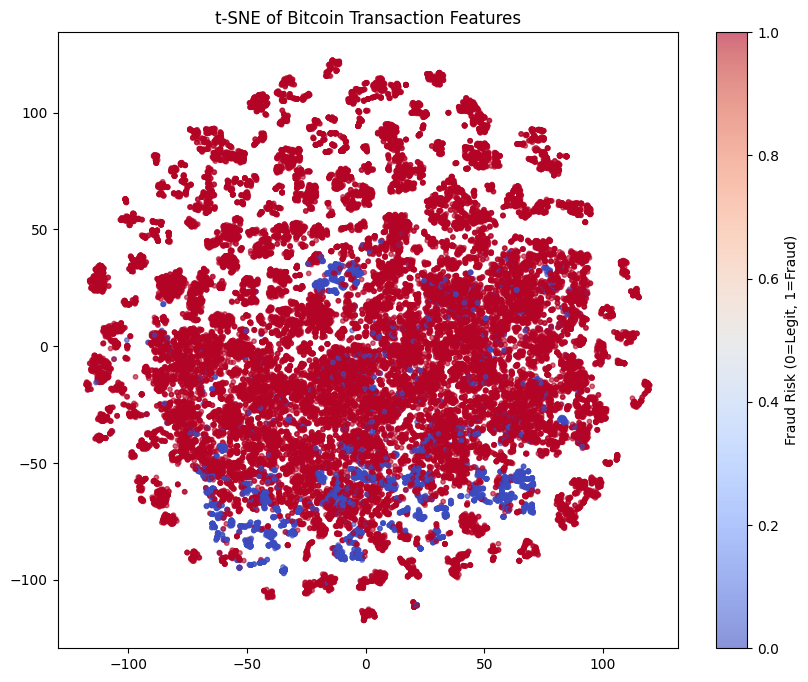

In [19]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.data import Data

# Load data SMARTLY
features = pd.read_csv("elliptic_txs_features.csv", header=None)
classes = pd.read_csv("elliptic_txs_classes.csv")
edgelist = pd.read_csv("elliptic_txs_edgelist.csv")

# Preprocess (keep only labeled nodes)
labeled_ids = classes[classes['class'] != 'unknown']['txId'].values
features_labeled = features[features[0].isin(labeled_ids)]
class_labeled = classes[classes['class'] != 'unknown']

# Convert to PyG Data format
x = torch.tensor(features_labeled.iloc[:, 1:].values, dtype=torch.float)
y = torch.tensor(class_labeled['class'].map({'1':0, '2':1}).values, dtype=torch.long)

# Create edge indices
edge_index = torch.tensor(edgelist.values.T, dtype=torch.long)

# Build graph data object
data = Data(x=x, edge_index=edge_index, y=y)

# Visualize clusters with t-SNE (lightning fast)
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
embeddings = tsne.fit_transform(data.x.numpy())

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(
    embeddings[:, 0], embeddings[:, 1],
    c=data.y.numpy(), 
    cmap='coolwarm', 
    alpha=0.6,
    s=10
)
plt.colorbar(label='Fraud Risk (0=Legit, 1=Fraud)')
plt.title("t-SNE of Bitcoin Transaction Features")
plt.savefig("fraud_clusters_tsne.png", dpi=120)